<a href="https://colab.research.google.com/github/harikrish13/AI-Car-Parking/blob/main/NLP_Diaster_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Training**

In [2]:
import cv2
import csv

In [3]:
filename = r"/content/drive/MyDrive/NLPD/train.csv"
f = open(filename, 'r')
f = csv.DictReader(f)
for i in f:
  print(i)

Streaming output truncated to the last 5000 lines.
{'id': '3750', 'keyword': 'destruction', 'location': 'All Around the World', 'text': 'How can we help save a beautiful town in Ontario from destruction by a power plant developer?\nhttp://t.co/hlD5xLYwBn', 'target': '0'}
{'id': '3752', 'keyword': 'destruction', 'location': '', 'text': 'Crackdown 3 Destruction Restricted to Multiplayer: Crackdown 3 impressed earlier this week with a demonstratio... http://t.co/LMWKjsYCgj', 'target': '0'}
{'id': '3753', 'keyword': 'destruction', 'location': 'Valle Del Sol', 'text': '@DanHRothschild Greed is the fuel of self-destruction. #Takecare', 'target': '0'}
{'id': '3754', 'keyword': 'destruction', 'location': 'Georgia, USA', 'text': '@cinla1964 @windowgatribble The Contrasts of Foreboding destruction enhanced by Expansive divisions of color saturation contrast and hue!', 'target': '0'}
{'id': '3756', 'keyword': 'destruction', 'location': 'New York NYC', 'text': "Russian authorities to take account 

In [4]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 28.6 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.15.0
KerasNLP version: 0.7.0


In [6]:
train = pd.read_csv("/content/drive/MyDrive/NLPD/train.csv")
test = pd.read_csv("/content/drive/MyDrive/NLPD/test.csv")

print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train["length"] = train["text"].apply(lambda x : len(x))
test["length"] = test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(train["length"].describe())
print()

print("Test Length Stat")
print(test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


Preprocess

In [10]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [11]:
from sklearn.model_selection import train_test_split

X = train["text"]
y = train["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))


6090 6090
1523 1523


In [12]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

6090 6090
1523 1523


**SVC Classifier**

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

tfidf_vectorizer = TfidfVectorizer(max_features=160)  # Use the same sequence length as in your DistilBERT example
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear')  # You can choose different kernels (linear, rbf, etc.)
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_tfidf)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.737360472751149


**BERT**

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

X = train["text"]
y = train["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Loading the Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and obtain BERT embeddings for training data
X_train_embeddings = []
for text in X_train:
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    X_train_embeddings.append(embeddings)

X_train_embeddings = np.concatenate(X_train_embeddings, axis=0)

# Tokenize and obtain BERT embeddings for testing data
X_test_embeddings = []
for text in X_test:
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    X_test_embeddings.append(embeddings)

X_test_embeddings = np.concatenate(X_test_embeddings, axis=0)

# Train the SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_embeddings, y_train)

# Predictions on the test set
y_pred = svm_classifier.predict(X_test_embeddings)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Accuracy: 0.8056467498358503


In [15]:
pip install seaborn matplotlib

Confusion Matrix:
[[742 132]
 [164 485]]


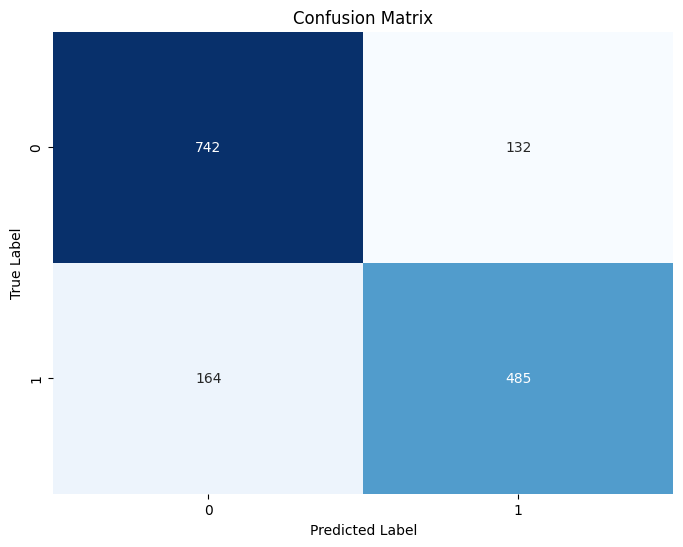

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = svm_classifier.predict(X_test_embeddings)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
